## Analyze A/B Test Results
> Stephanie Anderton  
> July 2018


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
users_converted = df['converted'].sum() / df['user_id'].nunique()
users_converted

0.12126269856564711

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
# number of times 'new_page' OR 'treatment' occurs
num_new_page_or_treatment = df.query('landing_page == "new_page" | group == "treatment"').count()[0]
num_new_page_or_treatment

149204

In [7]:
# number of times 'new_page' and 'treatment' DO line up
num_new_page_with_treatment = df.query('landing_page == "new_page" & group == "treatment"').count()[0]
num_new_page_with_treatment

145311

In [8]:
# number of times that 'new_page' and 'treatment' DO NOT line up
num_new_page_or_treatment - num_new_page_with_treatment

3893

f. Do any of the rows have missing values?

In [9]:
# check for missing data
df.isnull().any(axis=1).any()

False

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

> **_My answer:_**
>
> Remove these rows. We should only use the rows that we can feel confident in the accuracy of the data.

In [10]:
# drop all rows where the treatment is not aligned with new_page and 
# control is not aligned with old_page
df2 = df.drop(df[(df['landing_page'] == 'new_page') ^ (df['group'] == 'treatment')].index)

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [12]:
# number of unique user_ids in df2
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
# display rows with duplicate user_id entries
df2.loc[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [14]:
# display all rows for the user with id 773192
df2.loc[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
# drop the later entry for user_id 773192
df2.drop([2893], inplace=True)

In [16]:
# Double-check duplicates again - should be none
df2.loc[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [17]:
# P(Converted)
p_converted = df2['converted'].sum() / df2.shape[0]; p_converted

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
# P(Converted | Old Page), all control group users got the Old Page
p_converted_in_control = df2.query('group == "control"')['converted'].mean()
p_converted_in_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
# P(Converted | New Page), all treatment group users got the New Page
p_converted_in_treatment = df2.query('group == "treatment"')['converted'].mean()
p_converted_in_treatment

0.11880806551510564

d. What is the probability that an individual received the new page?

In [20]:
# P(New Page), would be the same as P(Treatment)
p_treatment = df2.query('landing_page == "new_page"').count()[0] / df2.shape[0]
p_treatment

0.5000619442226688

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

In [21]:
(p_treatment * p_converted_in_treatment) / p_converted

0.49676286939257047

> **_My answer:_**
>
> The probability (or proportion) of the new treatment page leading to conversion is 49.68% (conversely the probability for the old page is 50.32%). These findings would suggest that the conversion rates are essentially the same, and that the new treatment page does not generate any more conversions than the old one.
>
> _(Given that all users in the Control group get the 'old page', and all users in the Treatment group get the 'new page', we will use the terms Old Page and New Page.)_
>
> Using Bayes Rule we can find:
>
> $$P(New \: Page \mid Converted) = \frac{P(New \: Page) \: P(Converted \mid New \: Page) )}{P(Converted)}$$
> Where:
> ```
P(Converted) = 0.1196
P(Converted | Old Page) = 0.1204
P(Converted | New Page) = 0.1188
P(New Page) = 0.5001
```
>

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

> **_My answer:_**
>
> $$
H_0: p_{new}-p_{old} \le 0 \\
H_1: p_{new}-p_{old} > 0
$$
>

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [22]:
p_new = p_converted; p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null?

In [23]:
p_old = p_converted; p_old

0.11959708724499628

c. What is $n_{new}$?

In [24]:
# number of entries in the treatment df, 'new_page'
n_new = df2.query('group == "treatment"').shape[0]; n_new

145310

d. What is $n_{old}$?

In [25]:
# number of entries in the control df, 'old_page'
n_old = df2.query('group == "control"').shape[0]; n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [26]:
new_page_converted = np.random.choice([0,1], size=n_new, p=[1-p_new, p_new])
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [27]:
old_page_converted = np.random.choice([0,1], size=n_old, p=[1-p_old, p_old])
old_page_converted

array([1, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [28]:
new_page_converted.mean() - old_page_converted.mean()

-0.0013372023838366942

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [29]:
p_diffs = []

for _ in range(10000):
    new_page_converted_mean = np.random.choice([0,1], size=n_new, p=[1-p_new, p_new]).mean()
    old_page_converted_mean = np.random.choice([0,1], size=n_old, p=[1-p_old, p_old]).mean()
    p_diffs.append(new_page_converted_mean - old_page_converted_mean)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

In [30]:
# calculate the actual difference in proportions for convert rates as observed in the dataframe,
# from Part I, #4. b and c, above
obs_diff = p_converted_in_treatment - p_converted_in_control

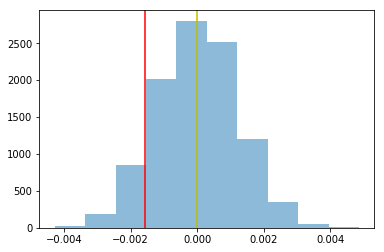

In [31]:
# convert to numpy array
p_diffs = np.array(p_diffs)

# plot distribution of differences in proportions - this should be normally distributed
plt.hist(p_diffs, alpha=0.5);
plt.axvline(x=obs_diff, color='r');    # difference in observed rates
plt.axvline(x=p_diffs.mean(), color='y');    # mean of differences

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [32]:
# proportion of p_diffs greater than the observed difference (compute p-value)
(p_diffs > obs_diff).mean()

0.9042

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

> _**My answer:**_
>
> The value computed in part **j.** is called the p-value in scientific studies, and is used to determine whether the observed difference is statistically significant. If the p-value is less than a (typical) type I error rate of 0.05, then this would suggest that there is a statistically significant difference, and that we reject the null hypothesis.
> 
> However, with the computed p-value of 90% (> type 1 error rate of 0.05) this would suggest that there is no significant difference between the new and old pages; the new treatment page does NOT increase the conversion rate.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [35]:
import statsmodels.api as sm

convert_old = df2.query("landing_page == 'old_page' and converted == 1").shape[0]
convert_new = df2.query("landing_page == 'new_page' and converted == 1").shape[0]
n_old = df2.query("landing_page == 'old_page'").shape[0]
n_new = df2.query("landing_page == 'new_page'").shape[0]

In [60]:
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [63]:
# perform a one-tail test
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

In [37]:
# how significant is our z-score?
from scipy.stats import norm
norm.cdf(z_score)

0.9050583127590245

In [59]:
# get the critical value at 95% confidence level,
# the proportions_ztest() computed above in part (m) is for a one_tail test
# critical value for one-tail test = 1.645
norm.ppf(1-0.05)

1.6448536269514722

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

> _**My answer:**_
>
> From the previous question, part **m.** we can interpret the results:
- The computed z-score of -1.311 is less than the critical z-score of 1.645 for a one-tail test
- The computed p-value of 0.905 is greater than the critical p-value (type 1 error rate) of 0.05
>
> These suggest that there is no significant difference between the conversion rates of the old and new pages.
> 
> These findings are also in agreement with those in parts **j.** and **k.**, where the p-value was calculated as 0.904; in other words, this test also suggests that we fail to reject the null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

> _**My answer:**_
>
> Since the response variable, `converted`, is either a 0 or a 1, we will perform **logistic regression**; this approach is used when we want to predict only two possible outcomes.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [39]:
df2['intercept'] = 1

df2['ab_page'] = (df2['group'] == "treatment").astype(int)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [40]:
lm1 = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results1 = lm1.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [41]:
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 11 Jul 2018   Pseudo R-squ.:               8.077e-06
Time:                        01:30:29   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [42]:
# compute the exponents for the coefficients
np.exp(results1.params)

intercept    0.136863
ab_page      0.985123
dtype: float64

In [43]:
# compute the inverse of the exponents for the coefficients since they are less than 1
1 / np.exp(results1.params)

intercept    7.306593
ab_page      1.015102
dtype: float64

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

> **_My answer:_**
>
> The p-value associated with **ab_page**, as shown in the Logit results summary, is 0.190, which differs greatly from the p-value of 0.905 found in **Part II**.
>
> The null and alternative hypotheses from **Part II** were:  
> $$H_0: p_{new}-p_{old} \le 0 \\
H_1: p_{new}-p_{old} > 0$$
> 
> For the Logistic regression method, the null and alternative hypotheses are:  
> $$H_0: p_{new}-p_{old} = 0 \\
H_1: p_{new}-p_{old} \neq 0$$
>
> For **Part II** the null hypothesis is **_less than or equal to_**, a one-tail test, while the logistic regression is simply **_NOT equal to_**, a two-tail test. This two-tail test is more rigorous than the one-tail test.  
>
>Despite the large difference, the p-value from the regression model is still greater than the typical type 1 error rate of 0.05, suggesting that we fail to reject the null hypothesis: in other words, that there is no significant difference in conversion rates between the old and new pages.
>

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

> **_My answer:_**
>
> It is a good idea to consider other factors to add to a regression model when the true relationship does not appear to be linear. There may be other variables that have an impact on the response variable, which when added help to make a better fit.
>
> The disadvantage of adding predictor variables to a regression model is that the interpretation of coefficients becomes more difficult. In some instances multicollinearity may exist, this occurs when predictor variables are related to one another. This has the effect of making the coefficient estimates less stable, producing large standard deviations.
>

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [44]:
# read in the countries.csv dataset
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [45]:
df_new['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [46]:
### Create the necessary dummy variables for the country
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


Plot the means of the variables to see if there is any correlation:

In [47]:
df_new.groupby(['country'], as_index=False)['country', 'converted', 'ab_page'].mean()

,country,converted,ab_page
0,CA,0.115318,0.503552
1,UK,0.120594,0.498247
2,US,0.119547,0.500459


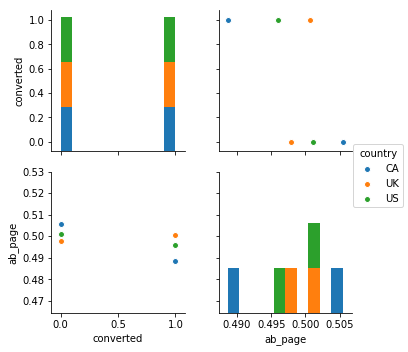

In [48]:
import seaborn as sns

sns.pairplot(df_new.groupby(['country', 'converted'], 
                            as_index=False)['country', 'converted', 'ab_page'].mean(), hue="country");

Fit a logistic regression model using **converted** and **CA** as the baseline, to predict conversion.

In [49]:
lm2 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US']])
results2 = lm2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 11 Jul 2018   Pseudo R-squ.:               2.323e-05
Time:                        01:30:34   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

In [50]:
# compute the exponents for the coefficients
np.exp(results2.params)

intercept    0.131332
ab_page      0.985168
UK           1.051944
US           1.041599
dtype: float64

In [51]:
# we compute the inverse only on the 'ab_page' coefficient since it is negative, and its exponent less than 1
1 / np.exp(results2.params.ab_page)

1.0150555970226345

> **_My answer:_**
>
> To answer the question: Does it appear that country had an impact on conversion?
>
> No, it does not appear that the country had an impact on conversion.
- The p-values for the UK (0.074) and US (0.130) variables are both greater than the type I error rate of 0.05, indicating that there is no significant difference compared with the conversion rate for CA.
- The confidence intervals for the UK (-0.005, 0.106) and US (-0.012, 0.093) overlap a lot, indicating that they are not very differenct from each other either.
- The coefficients for UK and US are very close to 1, which would suggest that a 1 unit increase in either of them would be about 1 times as likely as for CA, holding all other variables constant.
>
> Also, from the pairplot of the means above, if we connect the dots in the ab_page vs. converted plots for each country, the lines are very close to one another. This reflects the suggestion that country does not have an impact on conversion.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [52]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [53]:
# create new columns for interactions
df_new['UK_ab_page'] = df_new['UK'] * df_new['ab_page']
df_new['US_ab_page'] = df_new['US'] * df_new['ab_page']

In [54]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,UK_ab_page,US_ab_page
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,1,0


Fit a model to predict conversion using **ab_page**, and the interaction variables **UK_ab_page** and **US_ab_page**; **converted** and **CA** are the baseline.

In [55]:
lm3 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US', 'UK_ab_page', 'US_ab_page']])
results3 = lm3.fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 11 Jul 2018   Pseudo R-squ.:               3.482e-05
Time:                        01:30:37   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US             0.0175      0.038      0.465      0.642      -0.056       0.091
UK_ab_page     0.0783      0.057      1.378      0.168      -0.033       0.190
US_ab_page     0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

In [56]:
# compute the exponents for the coefficients
np.exp(results3.params)

intercept     0.134794
ab_page       0.934776
UK            1.011854
US            1.017682
UK_ab_page    1.081428
US_ab_page    1.048001
dtype: float64

In [57]:
# we compute the inverse only on the 'ab_page' coefficient since it is negative, and its exponent less than 1
1 / np.exp(results3.params.ab_page)

1.0697747746096131

> **_My answer:_**
>
> To answer the question: Does it appear that there is an interaction between page and country that has an impact on conversion?
>
> No! It does not appear that there is an interaction between page and country that has an impact on conversion. From the results summary we see the following:
- The p-values for both the interaction variables are greater than the type 1 error rate of 0.05: UK_ab_page's is 0.168, and US_ab_page's is 0.383.
- The p-values for the UK and US are also much greater than the type 1 error rate of 0.05: UK's is 0.767 and US's is 0.642.
- All the coefficients are very close to 1, indicating that they are 1 times as likely to convert than as an individual from CA, holding all others constant. Essentially, 1 times as likely is the same as just as likely.
  - UK = 1.011854
  - US = 1.017682
  - UK_ab_page = 1.081428
  - US_ab_page = 1.048001
  - ab_page = 1.0697747746096131
>